In [1]:
# load packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# Load all raw datasets from the 'data' folder ---

customers     = pd.read_csv('data/customers.csv')
sessions      = pd.read_csv('data/sessions.csv')
events1       = pd.read_csv('data/events1.csv')
events2       = pd.read_csv('data/events2.csv')
orders        = pd.read_csv('data/orders.csv')
order_items   = pd.read_csv('data/order_items.csv')
products      = pd.read_csv('data/products.csv')

print('Datasets loaded')

Datasets loaded


In [2]:
# Combine the two events dataframes into one
events = pd.concat([events1, events2], axis=0, ignore_index=True)

# quick confirmation
print("Combined events dataframe shape:", events.shape)

Combined events dataframe shape: (760958, 10)


# **Part 1 - Understanding and Initial Exploration of each Dataset**

<div style="background-color:lightcyan;">
    
- There are 6 datasets, generally already clean
    
- Only Events (clickstream data) had null values, which is expected
  
- all date information coded as objects and had to be converted to datetime
</div>


### **Customers** dataset

In [5]:
customers.head()

,customer_id,name,email,country,age,signup_date,marketing_opt_in
0,1,Jennifer Salinas,nicholas59@example.org,JP,71,2020-09-04,True
1,2,Phillip Ramos,christinarubio@example.com,IN,26,2020-04-05,False
2,3,Dawn Fowler,jessica03@example.org,BR,21,2023-08-31,True
3,4,Mario Butler,paula27@example.org,FR,63,2022-06-30,True
4,5,Amber Brown,kevin85@example.net,BR,19,2022-07-22,True


In [6]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       20000 non-null  int64 
 1   name              20000 non-null  object
 2   email             20000 non-null  object
 3   country           20000 non-null  object
 4   age               20000 non-null  int64 
 5   signup_date       20000 non-null  object
 6   marketing_opt_in  20000 non-null  bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 957.2+ KB


In [7]:
customers.describe()

,customer_id,age
count,"20,000.00","20,000.00"
mean,"10,000.50",46.49
std,"5,773.65",16.77
min,1.00,18.00
25%,"5,000.75",32.00
50%,"10,000.50",46.50
75%,"15,000.25",61.00
max,"20,000.00",75.00


In [8]:
customers.nunique()

customer_id         20000
name                17915
email               20000
country                17
age                    58
signup_date          2131
marketing_opt_in        2
dtype: int64

In [9]:
customers.isna().sum()

customer_id         0
name                0
email               0
country             0
age                 0
signup_date         0
marketing_opt_in    0
dtype: int64

<div style="background-color: honeydew;">
Need to:
    
1. convert signup_date from object to date
2. calculate tenure for each customers
3. remove exact duplicates
4. check for duplicate names (unique names < unique customer_ids and email addresses) 
                                               </unique>

In [10]:
# 1. Convert signup_date to datetime format
customers['signup_date'] = pd.to_datetime(customers['signup_date'], errors='coerce')

# verify conversion
print(customers['signup_date'].dtype)
print(customers['signup_date'].head())

datetime64[ns]
0   2020-09-04
1   2020-04-05
2   2023-08-31
3   2022-06-30
4   2022-07-22
Name: signup_date, dtype: datetime64[ns]


In [11]:
# check for any failed conversions
customers[customers['signup_date'].isna()]

,customer_id,name,email,country,age,signup_date,marketing_opt_in


In [12]:
# 2. calculate tenure usinng the latest date in the dataset

# Calculate reference date as the most recent signup date
reference_date = customers['signup_date'].max()

# Calculate tenure in days
customers['tenure_days'] = (reference_date - customers['signup_date']).dt.days

# Quick check
customers[['signup_date', 'tenure_days']].head()


,signup_date,tenure_days
0,2020-09-04,1883
1,2020-04-05,2035
2,2023-08-31,792
3,2022-06-30,1219
4,2022-07-22,1197


In [13]:
# 3. drop duplicates
customers.drop_duplicates(inplace=True)
print('process complete')

process complete


In [14]:
#4 check duplicate names

# Find duplicated names
duplicated_names = customers['name'][customers['name'].duplicated()].unique()

duplicated_names

array(['Joshua Pratt', 'Benjamin Smith', 'James Smith', ...,
       'James Allen', 'Amanda Miller', 'Christopher Hill'], dtype=object)

In [15]:
# show record of duplicate names

customers[customers['name'].isin(duplicated_names)].sort_values(by='name')


,customer_id,name,email,country,age,signup_date,marketing_opt_in,tenure_days
4681,4682,Aaron Davis,tevans@example.com,DE,20,2023-12-16,True,685
5757,5758,Aaron Davis,tara02@example.org,ES,60,2020-02-05,True,2095
9989,9990,Aaron Davis,bobby25@example.net,FR,49,2024-05-11,True,538
1847,1848,Aaron Edwards,charleswilliams@example.net,US,50,2024-08-29,False,428
5292,5293,Aaron Edwards,berrylisa@example.net,DE,31,2022-08-20,True,1168
...,...,...,...,...,...,...,...,...
18395,18396,Zachary Evans,lewisanthony@example.org,FR,68,2021-09-16,False,1506
4277,4278,Zachary Morris,richcharles@example.org,US,63,2021-12-02,True,1429
18892,18893,Zachary Morris,cantumatthew@example.org,GB,29,2022-04-16,True,1294
19923,19924,Zachary Smith,jeffreyprince@example.net,ZA,60,2021-06-02,False,1612


In [16]:
# Count occurrences of each (name, age, country) combination
dup_counts = customers.groupby(['name', 'age', 'country']).size().reset_index(name='count')

# Filter only combinations that appear more than once
dup_counts[dup_counts['count'] > 1]


,name,age,country,count
4910,David Powell,36,US,2
7608,James Miller,72,IN,2
9246,John Moore,53,MX,2
10891,Kenneth James,64,US,2


<div style="background-color:mistyrose;">
Overwhelming majority of the duplicate  names are people of different ages, from different countries, so definitely different individuals.  

There are 4 names in the record that have the same age and country; but will keep them as it is still within realm of possibility that these cases exist.
</div>

In [17]:
# print shape of dataset (see if rows changed post drop of duplicates)
print(customers.shape)

(20000, 8)


### **Sessions** dataset

In [18]:
sessions.head()

,session_id,customer_id,start_time,device,source,country
0,1,12360,2021-12-27T00:01:36,mobile,email,DE
1,2,13917,2025-01-31T21:29:42,desktop,organic,PL
2,3,1022,2024-02-19T00:52:50,tablet,organic,FR
3,4,2882,2024-08-04T19:54:31,mobile,direct,GB
4,5,1286,2022-06-28T13:58:08,desktop,email,ES


In [19]:
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   session_id   120000 non-null  int64 
 1   customer_id  120000 non-null  int64 
 2   start_time   120000 non-null  object
 3   device       120000 non-null  object
 4   source       120000 non-null  object
 5   country      120000 non-null  object
dtypes: int64(2), object(4)
memory usage: 5.5+ MB


In [20]:
sessions.nunique()

session_id     120000
customer_id     19945
start_time     119962
device              3
source              6
country            17
dtype: int64

In [21]:
sessions.isna().sum()

session_id     0
customer_id    0
start_time     0
device         0
source         0
country        0
dtype: int64

<div style="background-color: honeydew;">
Need to:
    
1.  convert start_time from object to datetime
2.  remove duplicates
3.  basic exploratory - how many events per customer?
                                               </unique>

In [22]:
# 1. convert start_time to date

sessions['start_time'] = pd.to_datetime(sessions['start_time'], errors='coerce')

#verify conversion
print(sessions['start_time'].dtype)
sessions['start_time'].head()

datetime64[ns]


0   2021-12-27 00:01:36
1   2025-01-31 21:29:42
2   2024-02-19 00:52:50
3   2024-08-04 19:54:31
4   2022-06-28 13:58:08
Name: start_time, dtype: datetime64[ns]

In [23]:
#Check for failed conversions
sessions[sessions['start_time'].isna()]

,session_id,customer_id,start_time,device,source,country


In [24]:
# 2. remove duplicates
sessions.drop_duplicates(inplace=True)
print('process complete, shape of file', sessions.shape)

process complete, shape of file (120000, 6)


In [25]:
# check that all customer_id entries in sessions dataframe are in customers data frame

sessions['customer_id'].isin(customers['customer_id']).all()

True

In [26]:
# 3 - Basic exploratory, sessions per customer

sessions_per_customer = sessions.groupby('customer_id')['session_id'].nunique().reset_index()

sessions_per_customer.columns = ['customer_id', 'num_sessions']

sessions_per_customer['num_sessions'].describe()


count   19,945.00
mean         6.02
std          2.45
min          1.00
25%          4.00
50%          6.00
75%          8.00
max         17.00
Name: num_sessions, dtype: float64

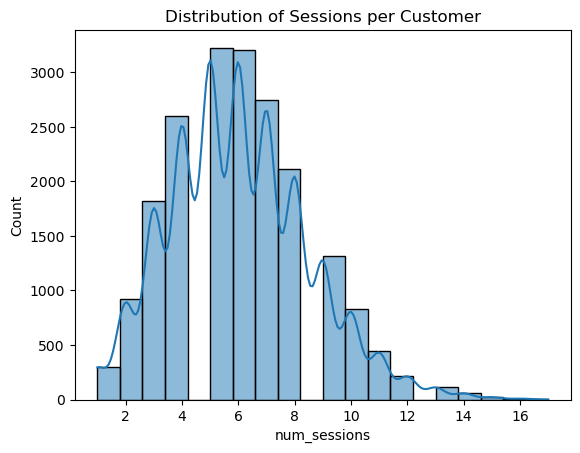

In [27]:
# Visualize sessions per customer

sns.histplot(sessions_per_customer['num_sessions'], bins=20, kde=True)
plt.title("Distribution of Sessions per Customer")
plt.show()

<div style="background-color:mistyrose;">
The max number of sessions per customer appears high, but the distribution looks "normal"

Based on internet research, real e-commerce customer do show heavy tail usage.
</div>

### **Events** dataset

In [28]:
events.head()

,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd
0,1,1,2021-12-27T00:08:36,page_view,93.00,NaN,NaN,NaN,NaN,NaN
1,2,1,2021-12-27T00:16:36,page_view,"1,005.00",NaN,NaN,NaN,NaN,NaN
2,3,1,2021-12-27T00:18:01,add_to_cart,"1,005.00",1.00,NaN,NaN,NaN,NaN
3,4,1,2021-12-27T00:45:36,page_view,918.00,NaN,NaN,NaN,NaN,NaN
4,5,1,2021-12-27T01:03:36,page_view,946.00,NaN,NaN,NaN,NaN,NaN


In [29]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760958 entries, 0 to 760957
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   event_id      760958 non-null  int64  
 1   session_id    760958 non-null  int64  
 2   timestamp     760958 non-null  object 
 3   event_type    760958 non-null  object 
 4   product_id    682469 non-null  float64
 5   qty           143126 non-null  float64
 6   cart_size     44909 non-null   float64
 7   payment       33580 non-null   object 
 8   discount_pct  33580 non-null   float64
 9   amount_usd    33580 non-null   float64
dtypes: float64(5), int64(2), object(3)
memory usage: 58.1+ MB


In [30]:
events.describe()

,event_id,session_id,product_id,qty,cart_size,discount_pct,amount_usd
count,"760,958.00","760,958.00","682,469.00","143,126.00","44,909.00","33,580.00","33,580.00"
mean,"380,479.50","60,153.50",652.31,1.30,2.29,7.16,133.81
std,"219,669.80","34,613.12",340.28,0.78,1.61,7.47,152.13
min,1.00,1.00,1.00,1.00,1.00,0.00,2.80
25%,"190,240.25","30,314.25",368.00,1.00,1.00,0.00,40.30
50%,"380,479.50","60,176.00",674.00,1.00,2.00,5.00,86.46
75%,"570,718.75","90,110.00",954.00,1.00,3.00,15.00,174.27
max,"760,958.00","120,000.00","1,197.00",4.00,13.00,20.00,"2,984.58"


In [31]:
events.isna().sum()

event_id             0
session_id           0
timestamp            0
event_type           0
product_id       78489
qty             617832
cart_size       716049
payment         727378
discount_pct    727378
amount_usd      727378
dtype: int64

In [32]:
events.nunique()

event_id        760958
session_id      120000
timestamp       759270
event_type           4
product_id        1197
qty                  4
cart_size           13
payment              4
discount_pct         5
amount_usd       16934
dtype: int64

<div style="background-color: honeydew;">
Need to:
    
1.  convert timestamp from object to datetime
2.  ensure null entries are coded as "NaN"
3.  remove duplicates
4.  ensure all session_id entries in events dataframe are also in the sessions dataframe
5.  basic exploratory: what are the unique event_types, how many events per session, conversion rate?
                                               </unique>

In [33]:
# 1. convert timestamp from object to time stamp
events['timestamp'] = pd.to_datetime(events['timestamp'], errors='coerce')

# verify conversion
print(events['timestamp'].dtype)
events['timestamp'].head()

datetime64[ns]


0   2021-12-27 00:08:36
1   2021-12-27 00:16:36
2   2021-12-27 00:18:01
3   2021-12-27 00:45:36
4   2021-12-27 01:03:36
Name: timestamp, dtype: datetime64[ns]

In [34]:
# Check for failed conversions
events[events['timestamp'].isna()]

,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd


In [35]:
# 2. Ensure all null entries are "NaN"
events = events.replace(['', ' ', 'NULL', 'null', 'None'], np.nan)

In [36]:
# 3. remove duplicates
events.drop_duplicates(inplace=True)
print('process complete, shape of file', events.shape)

process complete, shape of file (760958, 10)


In [37]:
# 4. ensure all session_id entries in events dataframe are also in the sessions dataframe

events['session_id'].isin(sessions['session_id']).all()

True

In [38]:
# 5A - Basic exploratory : what are the different event_types?
events['event_type'].unique()


array(['page_view', 'add_to_cart', 'checkout', 'purchase'], dtype=object)

In [39]:
# 5B - Basic Exploratory : #Events per sessions
events_per_session = events.groupby('session_id')['event_id'].nunique().reset_index()

events_per_session.columns = ['session_id', 'num_events']

events_per_session.describe()


,session_id,num_events
count,"120,000.00","120,000.00"
mean,"60,000.50",6.34
std,"34,641.16",3.42
min,1.00,1.00
25%,"30,000.75",3.00
50%,"60,000.50",6.00
75%,"90,000.25",9.00
max,"120,000.00",17.00


In [40]:
# 5C - Basic exploratory : determine conversion rate of sessions

# Number of sessions that contain at least one purchase event
purchase_sessions = events.loc[events['event_type'] == 'purchase', 'session_id'].nunique()

# Total number of unique sessions in the events dataframe
total_sessions = events['session_id'].nunique()

# Conversion rate (% of sessions that ended in purchase)
conversion_rate = (purchase_sessions / total_sessions) * 100

print("Number of sessions with a purchase:", purchase_sessions)
print("Total sessions:", total_sessions)
print(f"Conversion rate: {conversion_rate:.2f}%")


Number of sessions with a purchase: 33580
Total sessions: 120000
Conversion rate: 27.98%


### **Orders** dataset

In [41]:
orders.head()

,order_id,customer_id,order_time,payment_method,discount_pct,subtotal_usd,total_usd,country,device,source
0,1,13917,2025-01-31T23:07:42,card,20,107.15,85.72,PL,desktop,organic
1,2,1022,2024-02-19T01:17:50,card,0,116.17,116.17,FR,tablet,organic
2,3,6145,2024-12-04T20:24:13,card,0,137.35,137.35,US,mobile,organic
3,4,3152,2024-07-17T08:50:47,card,15,32.18,27.35,BR,mobile,email
4,5,12378,2020-08-21T16:54:16,card,0,238.09,238.09,NL,desktop,paid


In [42]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33580 entries, 0 to 33579
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        33580 non-null  int64  
 1   customer_id     33580 non-null  int64  
 2   order_time      33580 non-null  object 
 3   payment_method  33580 non-null  object 
 4   discount_pct    33580 non-null  int64  
 5   subtotal_usd    33580 non-null  float64
 6   total_usd       33580 non-null  float64
 7   country         33580 non-null  object 
 8   device          33580 non-null  object 
 9   source          33580 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 2.6+ MB


In [43]:
orders.describe()

,order_id,customer_id,discount_pct,subtotal_usd,total_usd
count,"33,580.00","33,580.00","33,580.00","33,580.00","33,580.00"
mean,"16,790.50","10,010.63",7.16,144.00,133.81
std,"9,693.86","5,798.46",7.47,162.60,152.13
min,1.00,1.00,0.00,3.50,2.80
25%,"8,395.75","4,964.00",0.00,44.06,40.30
50%,"16,790.50","10,008.00",5.00,93.62,86.46
75%,"25,185.25","15,061.00",15.00,187.10,174.27
max,"33,580.00","19,999.00",20.00,"3,141.66","2,984.58"


In [44]:
orders.nunique()

order_id          33580
customer_id       16268
order_time        33578
payment_method        4
discount_pct          5
subtotal_usd      15227
total_usd         16934
country              17
device                3
source                6
dtype: int64

In [45]:
orders.isna().sum()

order_id          0
customer_id       0
order_time        0
payment_method    0
discount_pct      0
subtotal_usd      0
total_usd         0
country           0
device            0
source            0
dtype: int64

<div style="background-color: honeydew;">
Need to:
    
1.  convert order_time from object to datetime
2.  check out max  total_usd - is this an outlier?
3.  remove duplicates
4.  confirm all customer_id entries in orders dataframe are in the customer dataframe
5.  check if order_time is orders dataframe links with the timestamps in the event dataframe
6.  basic exploratory: how many orders per customer
                                               </unique>

In [46]:
#1. convert order_time to date time

orders['order_time'] = pd.to_datetime(orders['order_time'], errors='coerce')

# verify conversion
print(orders['order_time'].dtype)
orders['order_time'].head()


datetime64[ns]


0   2025-01-31 23:07:42
1   2024-02-19 01:17:50
2   2024-12-04 20:24:13
3   2024-07-17 08:50:47
4   2020-08-21 16:54:16
Name: order_time, dtype: datetime64[ns]

In [47]:
# check for failed conversions

orders[orders['order_time'].isna()].head()

,order_id,customer_id,order_time,payment_method,discount_pct,subtotal_usd,total_usd,country,device,source


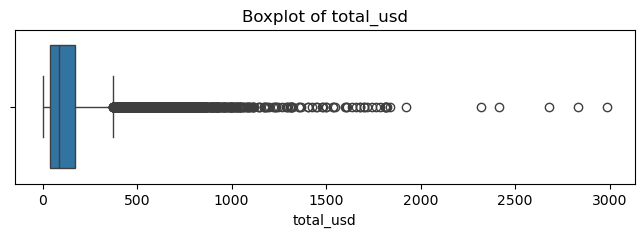

In [48]:
# 2 - visualize distribution of total_usd 

plt.figure(figsize=(8,2))
sns.boxplot(x=orders['total_usd'])
plt.title('Boxplot of total_usd')
plt.xlabel('total_usd')
plt.show()

<div style="background-color:mistyrose;">
There are a lot of purchases >$500, and those >$2000 do look to be more exceptions.  
I will not exclude them from the analysis, it may be good to understand who these consumers are 
(as a means to get more of them into the business)
</div>

In [49]:
# 3. Drop exact duplicate rows
orders = orders.drop_duplicates()
print(orders.shape)

(33580, 10)


In [50]:
# 3. confirm all customer_id entries in orders dataframe are in the customers dataframe

orders['customer_id'].isin(customers['customer_id']).all()

True

In [51]:
# 4. check if order_time in orders dataframe links with the timestamp in the event dataframe  

# Check if any exact matches exist
exact_matches = events['timestamp'].isin(orders['order_time']).sum()

print("Number of exact timestamp matches:", exact_matches)


Number of exact timestamp matches: 33723


<div style="background-color:mistyrose;">
There are exaact matches suggesting that timestamp and order_time can be the link between orders dataframe and events dataframe
</div>

In [52]:
# 5. Basic Exploratory - how many orders by customer

orders_per_customer = orders.groupby('customer_id')['order_id'].nunique().reset_index()

orders_per_customer.columns = ['customer_id', 'num_orders']

orders_per_customer.describe()


,customer_id,num_orders
count,"16,268.00","16,268.00"
mean,"10,002.05",2.06
std,"5,785.60",1.12
min,1.00,1.00
25%,"4,976.75",1.00
50%,"10,001.50",2.00
75%,"15,031.25",3.00
max,"19,999.00",9.00


### **order_items** dataset

In [53]:
order_items.head()

,order_id,product_id,unit_price_usd,quantity,line_total_usd
0,1,226,107.15,1,107.15
1,2,771,116.17,1,116.17
2,3,415,94.49,1,94.49
3,3,24,42.86,1,42.86
4,4,1157,32.18,1,32.18


In [54]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59163 entries, 0 to 59162
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        59163 non-null  int64  
 1   product_id      59163 non-null  int64  
 2   unit_price_usd  59163 non-null  float64
 3   quantity        59163 non-null  int64  
 4   line_total_usd  59163 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 2.3 MB


In [55]:
order_items.describe()

,order_id,product_id,unit_price_usd,quantity,line_total_usd
count,"59,163.00","59,163.00","59,163.00","59,163.00","59,163.00"
mean,"16,811.78",692.10,62.84,1.30,81.73
std,"9,687.82",329.20,62.06,0.79,106.36
min,1.00,1.00,3.50,1.00,3.50
25%,"8,454.00",411.00,21.64,1.00,24.77
50%,"16,838.00",738.00,44.65,1.00,49.92
75%,"25,203.00",980.00,79.45,1.00,98.68
max,"33,580.00","1,197.00",596.62,4.00,"2,376.92"


In [56]:
order_items.nunique()

order_id          33580
product_id         1195
unit_price_usd     1159
quantity              4
line_total_usd     3804
dtype: int64

In [57]:
order_items.isna().sum()

order_id          0
product_id        0
unit_price_usd    0
quantity          0
line_total_usd    0
dtype: int64

<div style="background-color: honeydew;">
Need to:
    
1.  remove duplicates
2.  check that all order_id entries are in orders data frame
3.  check that all product_id entries in order_items are in products dataframe
                                               </unique>

In [58]:
# 1. check for exact duplicates
order_items.duplicated().sum()  # exact duplicates


73

In [59]:
# Drop exact duplicate rows
order_items = order_items.drop_duplicates()

print("Order_items shape after dropping duplicates:", order_items.shape)

Order_items shape after dropping duplicates: (59090, 5)


In [60]:
# check for duplicates based on order_id and product_id
# In many datasets, duplicates occur when the same product is listed twice in the same order.

order_items.duplicated(subset=['order_id', 'product_id']).sum()  # duplicates based on key fields

37

In [61]:
# Keep first occurence
order_items = order_items.drop_duplicates(
    subset=['order_id', 'product_id'],
    keep='first'
)

print("Order_items shape after dropping duplicate order_id-product combinations:", order_items.shape)


Order_items shape after dropping duplicate order_id-product combinations: (59053, 5)


In [62]:
#2. check that all order_id entries in order_items are in orders data frame

order_items['order_id'].isin(orders['order_id']).all()

True

In [63]:
# 3.  check that all product_id entries in order_items are in products dataframe

order_items['product_id'].isin(products['product_id']).all()

True

### **products** dataset

In [64]:
products.head()

,product_id,category,name,price_usd,cost_usd,margin_usd
0,1,Electronics,SSD MediumBlue 149,570.28,352.69,217.59
1,2,Electronics,Keyboard DeepPink 696,498.13,263.13,235.00
2,3,Electronics,Headphones Orchid 188,548.53,309.60,238.93
3,4,Electronics,Smartwatch BurlyWood 664,268.36,153.56,114.80
4,5,Electronics,Smartwatch Cornsilk 328,63.69,42.65,21.04


In [65]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  1197 non-null   int64  
 1   category    1197 non-null   object 
 2   name        1197 non-null   object 
 3   price_usd   1197 non-null   float64
 4   cost_usd    1197 non-null   float64
 5   margin_usd  1197 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 56.2+ KB


In [66]:
products.describe()

,product_id,price_usd,cost_usd,margin_usd
count,"1,197.00","1,197.00","1,197.00","1,197.00"
mean,599.00,119.94,77.63,42.31
std,345.69,119.68,79.23,44.46
min,1.00,3.50,2.21,1.03
25%,300.00,38.54,23.53,12.24
50%,599.00,77.20,49.14,27.02
75%,898.00,165.42,103.67,55.44
max,"1,197.00",596.62,446.10,263.73


In [67]:
products.nunique()

product_id    1197
category         7
name          1197
price_usd     1161
cost_usd      1157
margin_usd    1096
dtype: int64

In [68]:
products.isna().sum()

product_id    0
category      0
name          0
price_usd     0
cost_usd      0
margin_usd    0
dtype: int64

<div style="background-color: honeydew;">
Need to remove any duplicates
                                               </unique>

In [69]:
# remove duplicates
products = products.drop_duplicates(subset=['product_id'], keep='first')

print("Products shape after dropping duplicate product_id values:", products.shape)


Products shape after dropping duplicate product_id values: (1197, 6)


In [70]:
# get unique categories
products['category'].unique()

array(['Electronics', 'Home & Kitchen', 'Beauty', 'Sports', 'Fashion',
       'Books', 'Toys'], dtype=object)

# Part 2 - Data Integration

## A - Customer-Level Modeling Dataset (for Segmentation)

<div style="background-color:lightcyan;">
    
Objective of this section is to createa customer dataset for purposes of segmentation.
    
It compiles information for unique customers and extracts data from all datasets
  
</div>

In [71]:
# Step 1. Merge order_items with products to attach category info

order_items_2 = order_items.merge(
    products,
    on="product_id",
    how="left"
)

order_items_2.head()


,order_id,product_id,unit_price_usd,quantity,line_total_usd,category,name,price_usd,cost_usd,margin_usd
0,1,226,107.15,1,107.15,Home & Kitchen,Toaster MediumSlateBlue 575,107.15,65.65,41.50
1,2,771,116.17,1,116.17,Fashion,Socks Orange 300,116.17,70.22,45.95
2,3,415,94.49,1,94.49,Beauty,Shampoo LawnGreen 601,94.49,58.26,36.23
3,3,24,42.86,1,42.86,Electronics,SSD Orchid 272,42.86,27.37,15.49
4,4,1157,32.18,1,32.18,Toys,Board Game DarkSeaGreen 297,32.18,22.43,9.75


In [72]:
# Step 2.1 Order-level aggregates from order_items_2

order_level_agg = (
    order_items_2
    .groupby("order_id")
    .agg(
        order_qty_total    = ("quantity", "sum"),
        order_revenue_from_items = ("price_usd", lambda x: np.sum(x)),  # adjust if needed
        n_distinct_products = ("product_id", "nunique"),
        n_distinct_categories = ("category", "nunique")
    )
    .reset_index()
)

order_level_agg.head()


,order_id,order_qty_total,order_revenue_from_items,n_distinct_products,n_distinct_categories
0,1,1,107.15,1,1
1,2,1,116.17,1,1
2,3,2,137.35,2,2
3,4,1,32.18,1,1
4,5,2,238.09,2,1


In [73]:
# Step 2.2  Attach order-level info back to orders

orders_2 = orders.merge(
    order_level_agg,
    on="order_id",
    how="left"
)

orders_2.head()


,order_id,customer_id,order_time,payment_method,discount_pct,subtotal_usd,total_usd,country,device,source,order_qty_total,order_revenue_from_items,n_distinct_products,n_distinct_categories
0,1,13917,2025-01-31 23:07:42,card,20,107.15,85.72,PL,desktop,organic,1,107.15,1,1
1,2,1022,2024-02-19 01:17:50,card,0,116.17,116.17,FR,tablet,organic,1,116.17,1,1
2,3,6145,2024-12-04 20:24:13,card,0,137.35,137.35,US,mobile,organic,2,137.35,2,2
3,4,3152,2024-07-17 08:50:47,card,15,32.18,27.35,BR,mobile,email,1,32.18,1,1
4,5,12378,2020-08-21 16:54:16,card,0,238.09,238.09,NL,desktop,paid,2,238.09,2,1


In [74]:
orders_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33580 entries, 0 to 33579
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   order_id                  33580 non-null  int64         
 1   customer_id               33580 non-null  int64         
 2   order_time                33580 non-null  datetime64[ns]
 3   payment_method            33580 non-null  object        
 4   discount_pct              33580 non-null  int64         
 5   subtotal_usd              33580 non-null  float64       
 6   total_usd                 33580 non-null  float64       
 7   country                   33580 non-null  object        
 8   device                    33580 non-null  object        
 9   source                    33580 non-null  object        
 10  order_qty_total           33580 non-null  int64         
 11  order_revenue_from_items  33580 non-null  float64       
 12  n_distinct_product

In [75]:
# Step 3.1 Aggregate at customer level using orders_enriched
customer_orders_agg = (
    orders_2
    .groupby("customer_id")
    .agg(
        n_orders             = ("order_id", "nunique"),
        total_revenue        = ("total_usd", "sum"),   # adjust if your column is named differently
        mean_order_value     = ("total_usd", "mean"),
        total_qty_purchased  = ("order_qty_total", "sum"),
        n_products_purchased = ("n_distinct_products", "sum"),  # or nunique across all items if you prefer
        n_categories_purchased = ("n_distinct_categories", "sum"),
        first_order_time     = ("order_time", "min"),
        last_order_time      = ("order_time", "max")
    )
    .reset_index()
)

customer_orders_agg.head()


,customer_id,n_orders,total_revenue,mean_order_value,total_qty_purchased,n_products_purchased,n_categories_purchased,first_order_time,last_order_time
0,1,2,115.39,57.69,3,2,2,2022-03-18 04:16:29,2025-06-25 16:02:53
1,2,2,68.52,34.26,2,2,2,2023-12-16 17:48:30,2025-01-02 02:48:29
2,3,1,66.72,66.72,1,1,1,2020-07-04 07:39:11,2020-07-04 07:39:11
3,4,2,279.86,139.93,5,3,2,2020-09-29 03:07:16,2023-08-01 00:50:26
4,5,3,271.29,90.43,4,4,3,2024-06-15 21:36:57,2025-01-30 02:03:28


In [76]:
# Step 3.2 Recency (days since last order)

if "last_order_time" in customer_orders_agg.columns:
    snapshot_date = customer_orders_agg["last_order_time"].max()
    customer_orders_agg["recency_days"] = (
        snapshot_date - customer_orders_agg["last_order_time"]
    ).dt.days


In [77]:
# confirm recency_days added

customer_orders_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16268 entries, 0 to 16267
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   customer_id             16268 non-null  int64         
 1   n_orders                16268 non-null  int64         
 2   total_revenue           16268 non-null  float64       
 3   mean_order_value        16268 non-null  float64       
 4   total_qty_purchased     16268 non-null  int64         
 5   n_products_purchased    16268 non-null  int64         
 6   n_categories_purchased  16268 non-null  int64         
 7   first_order_time        16268 non-null  datetime64[ns]
 8   last_order_time         16268 non-null  datetime64[ns]
 9   recency_days            16268 non-null  int64         
dtypes: datetime64[ns](2), float64(2), int64(6)
memory usage: 1.2 MB


In [78]:
# Step 4.1 – Session / event-level behavior features

events_sessions = events.merge(
    sessions[["session_id", "customer_id"]],
    on="session_id",
    how="left"
)

events_sessions.head()


,event_id,session_id,timestamp,event_type,product_id,qty,cart_size,payment,discount_pct,amount_usd,customer_id
0,1,1,2021-12-27 00:08:36,page_view,93.00,NaN,NaN,NaN,NaN,NaN,12360
1,2,1,2021-12-27 00:16:36,page_view,"1,005.00",NaN,NaN,NaN,NaN,NaN,12360
2,3,1,2021-12-27 00:18:01,add_to_cart,"1,005.00",1.00,NaN,NaN,NaN,NaN,12360
3,4,1,2021-12-27 00:45:36,page_view,918.00,NaN,NaN,NaN,NaN,NaN,12360
4,5,1,2021-12-27 01:03:36,page_view,946.00,NaN,NaN,NaN,NaN,NaN,12360


In [79]:
# Step 4.2 Create one-hot style flags for key event types

events_sessions["is_view"]       = (events_sessions["event_type"] == "page_view").astype(int)
events_sessions["is_cart"]       = (events_sessions["event_type"] == "add_to_cart").astype(int)
events_sessions["is_checkout"]   = (events_sessions["event_type"] == "checkout").astype(int)
events_sessions["is_purchase_ev"] = (events_sessions["event_type"] == "purchase").astype(int)

In [80]:
# confirm flags created
events_sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760958 entries, 0 to 760957
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_id        760958 non-null  int64         
 1   session_id      760958 non-null  int64         
 2   timestamp       760958 non-null  datetime64[ns]
 3   event_type      760958 non-null  object        
 4   product_id      682469 non-null  float64       
 5   qty             143126 non-null  float64       
 6   cart_size       44909 non-null   float64       
 7   payment         33580 non-null   object        
 8   discount_pct    33580 non-null   float64       
 9   amount_usd      33580 non-null   float64       
 10  customer_id     760958 non-null  int64         
 11  is_view         760958 non-null  int64         
 12  is_cart         760958 non-null  int64         
 13  is_checkout     760958 non-null  int64         
 14  is_purchase_ev  760958 non-null  int

In [81]:
# Step 4.3 Customer-level event aggregation

customer_events_agg = (
    events_sessions
    .groupby("customer_id")
    .agg(
        n_events          = ("event_id", "nunique"),
        n_views           = ("is_view", "sum"),
        n_add_to_cart     = ("is_cart", "sum"),
        n_checkouts       = ("is_checkout","sum"),
        n_purchase_events = ("is_purchase_ev", "sum"),
        n_sessions_with_events = ("session_id", "nunique")
    )
    .reset_index()
)

# Simple engagement ratios
customer_events_agg["views_per_session"] = (
    customer_events_agg["n_views"] / customer_events_agg["n_sessions_with_events"]
)

customer_events_agg["cart_to_view_rate"] = (
    customer_events_agg["n_add_to_cart"] / customer_events_agg["n_views"].replace(0, np.nan)
)

customer_events_agg["purchase_to_cart_rate"] = (
    customer_events_agg["n_purchase_events"] / customer_events_agg["n_add_to_cart"].replace(0, np.nan)
)

customer_events_agg.head()


,customer_id,n_events,n_views,n_add_to_cart,n_checkouts,n_purchase_events,n_sessions_with_events,views_per_session,cart_to_view_rate,purchase_to_cart_rate
0,1,41,28,8,3,2,5,5.60,0.29,0.25
1,2,23,17,2,2,2,3,5.67,0.12,1.00
2,3,37,30,4,2,1,5,6.00,0.13,0.25
3,4,40,29,6,3,2,9,3.22,0.21,0.33
4,5,51,34,9,5,3,9,3.78,0.26,0.33


In [82]:
# Step 5 – Combine all customer-level tables

# 6.1 Start from customers as the base
customer_model_df = customers.copy()

# 6.2 Join purchase aggregates
customer_model_df = customer_model_df.merge(
    customer_orders_agg,
    on="customer_id",
    how="left"
)

# 6.3 Join event aggregates
customer_model_df = customer_model_df.merge(
    customer_events_agg,
    on="customer_id",
    how="left"
)

customer_model_df.head()
customer_model_df.shape

(20000, 26)

In [83]:
# Step 6 Create category-level purchase features

# 6.1 Attach customer_id via orders
order_items_2 = order_items.merge(
    orders[["order_id", "customer_id"]],
    on="order_id",
    how="left"
)

# 6.2 Attach category via products
#    Adjust "category" if your column is named differently (e.g., "product_category")
order_items_2 = order_items_2.merge(
    products[["product_id", "category"]],
    on="product_id",
    how="left"
)


In [84]:
# 6.3 Aggregate quantity and revenue by customer and category
cust_cat = (
    order_items_2
    .groupby(["customer_id", "category"])
    .agg(
        qty_by_cat   = ("quantity", "sum"),
        rev_by_cat   = ("line_total_usd", "sum")  # adjust if you have line_total_usd
    )
    .reset_index()
)
# 6.4 Pivot categories into columns

# Pivot quantities
qty_pivot = cust_cat.pivot_table(
    index="customer_id",
    columns="category",
    values="qty_by_cat",
    fill_value=0
).add_prefix("qty_")

# Pivot revenues
rev_pivot = cust_cat.pivot_table(
    index="customer_id",
    columns="category",
    values="rev_by_cat",
    fill_value=0
).add_prefix("rev_")

# 6.5 Convert category purchases into binary flags
# Binary indicator: did the customer buy this category?
flag_pivot = (qty_pivot > 0).astype(int).add_prefix("flag_")


# 6.6 Merge these into your customer_model_df

# Merge quantity features
customer_model_df = customer_model_df.merge(
    qty_pivot,
    on="customer_id",
    how="left"
)

# Merge revenue features
customer_model_df = customer_model_df.merge(
    rev_pivot,
    on="customer_id",
    how="left"
)

# Merge flags
customer_model_df = customer_model_df.merge(
    flag_pivot,
    on="customer_id",
    how="left"
)

In [85]:
# Step 7 – Clean up / handle missing values

# 7.1 Identify numeric columns
numeric_cols = customer_model_df.select_dtypes(include=[np.number]).columns

# 7.2 Fill NaNs in numeric features with 0 (or other strategy)
customer_model_df[numeric_cols] = customer_model_df[numeric_cols].fillna(0)

# 7.3 Optional: drop customers with no activity at all
# (e.g., no orders, no events, no sessions)
activity_cols = ["n_orders", "n_events", "n_sessions"]
existing_activity_cols = [c for c in activity_cols if c in customer_model_df.columns]

if existing_activity_cols:
    customer_model_df = customer_model_df[
        customer_model_df[existing_activity_cols].sum(axis=1) > 0
    ]

customer_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19945 entries, 0 to 19999
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_id              19945 non-null  int64         
 1   name                     19945 non-null  object        
 2   email                    19945 non-null  object        
 3   country                  19945 non-null  object        
 4   age                      19945 non-null  int64         
 5   signup_date              19945 non-null  datetime64[ns]
 6   marketing_opt_in         19945 non-null  bool          
 7   tenure_days              19945 non-null  int64         
 8   n_orders                 19945 non-null  float64       
 9   total_revenue            19945 non-null  float64       
 10  mean_order_value         19945 non-null  float64       
 11  total_qty_purchased      19945 non-null  float64       
 12  n_products_purchased     19945 non-nu

In [86]:
# Save customer_model_df to CSV
customer_model_df.to_csv("data/customer_model_df.csv", index=False)

print("File saved to data/customer_model_df.csv")

File saved to data/customer_model_df.csv


<div style="background-color:mistyrose;">
There are 46 features in the modelling dataset - these will be reviewed and culled down, when necessary, at the EDA stage
</div>

## B - Session-Level Modeling Dataset

<div style="background-color:lightcyan;">
    
Objective of this section is to create a Sessions dataset for purposes of predictive modeling.
    
It combines data from three datasets:  sessions, events and customers.
</div>

In [87]:
# STEP 1 – Create the purchase intent label (target)

session_purchase = (
    events
    .assign(purchase_flag=lambda df: (df["event_type"] == "purchase").astype(int))
    .groupby("session_id")["purchase_flag"]
    .max()                         # any purchase in the session -> 1
    .rename("target_purchase")
)

In [88]:
# STEP 2 – Event-type counts per session (behavioral features)
# Counts of page_view, add_to_cart, checkout, purchase in each session:

event_type_counts = (
    events
    .groupby(["session_id", "event_type"])
    .size()
    .unstack(fill_value=0)         # columns: add_to_cart, checkout, page_view, purchase
)

In [89]:
# STEP 3 – Additional event-based aggregates per session

session_agg = (
    events
    .groupby("session_id")
    .agg(
        n_events            = ("event_id", "count"),
        n_distinct_products = ("product_id", "nunique"),
        total_quantity      = ("qty", "sum"),
        total_revenue_session = ("amount_usd", "sum"),
        avg_discount_session = ("discount_pct", "mean"),
    )
)

In [90]:
# STEP 4 – Combine event-based features + target into one table

session_event_features = (
    session_agg
    .join(event_type_counts, how="left")
    .join(session_purchase,    how="left")
)

# Make sure index is named and turned into a column
session_event_features.index.name = "session_id"
session_event_features = session_event_features.reset_index()

In [91]:
# STEP 5 – Compute session duration

# Last event per session
session_times = (
    events
    .groupby("session_id")
    .agg(last_event_time=("timestamp", "max"))
    .reset_index()
)

# Merge with sessions start_time and compute duration in minutes
session_times = (
    sessions[["session_id", "start_time"]]
    .merge(session_times, on="session_id", how="left")
)

session_times["session_duration_min"] = (
    session_times["last_event_time"] - session_times["start_time"]
).dt.total_seconds() / 60


***STEP 7 – Bring everything together at session level***

Merge:
1. sessions → device, source, country, customer_id, start_time
2. session_times → session_duration_min
3. session_event_features → behavioral features + target_purchase
4. customers → basic customer features

In [92]:
session_model_df = (
    sessions
    # add session duration
    .merge(
        session_times[["session_id", "session_duration_min"]],
        on="session_id",
        how="left"
    )
    # add event-based features + target
    .merge(session_event_features, on="session_id", how="left")
    # add customer features
    .merge(
        customers[["customer_id", "age", "signup_date", "marketing_opt_in"]],
        on="customer_id",
        how="left"
    )
)

In [93]:
# STEP 8 – Basic cleaning / filling
# Fill numeric NaNs (e.g., sessions with no purchases will have avg_discount_session = NaN → set to 0):

numeric_cols = [
    "session_duration_min",
    "n_events",
    "n_distinct_products",
    "total_quantity",
    "total_revenue_session",
    "avg_discount_session",
]

# Add event-type count cols that exist
for col in ["add_to_cart", "checkout", "page_view", "purchase"]:
    if col in session_model_df.columns:
        numeric_cols.append(col)

session_model_df[numeric_cols] = session_model_df[numeric_cols].fillna(0)

# Target is already 0/1 with no NaNs, but just to be safe:
session_model_df["target_purchase"] = session_model_df["target_purchase"].fillna(0).astype(int)


In [94]:
session_model_df.head()

,session_id,customer_id,start_time,device,source,country,session_duration_min,n_events,n_distinct_products,total_quantity,total_revenue_session,avg_discount_session,add_to_cart,checkout,page_view,purchase,target_purchase,age,signup_date,marketing_opt_in
0,1,12360,2021-12-27 00:01:36,mobile,email,DE,118.00,10,7,3.00,0.00,0.00,3,0,7,0,0,43,2024-08-12,False
1,2,13917,2025-01-31 21:29:42,desktop,organic,PL,98.00,8,5,1.00,85.72,20.00,1,1,5,1,1,68,2025-07-09,True
2,3,1022,2024-02-19 00:52:50,tablet,organic,FR,25.00,5,2,1.00,116.17,0.00,1,1,2,1,1,45,2023-03-31,False
3,4,2882,2024-08-04 19:54:31,mobile,direct,GB,53.00,2,2,0.00,0.00,0.00,0,0,2,0,0,23,2022-05-20,False
4,5,1286,2022-06-28 13:58:08,desktop,email,ES,89.00,6,6,0.00,0.00,0.00,0,0,6,0,0,22,2021-06-15,False


In [95]:
session_model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   session_id             120000 non-null  int64         
 1   customer_id            120000 non-null  int64         
 2   start_time             120000 non-null  datetime64[ns]
 3   device                 120000 non-null  object        
 4   source                 120000 non-null  object        
 5   country                120000 non-null  object        
 6   session_duration_min   120000 non-null  float64       
 7   n_events               120000 non-null  int64         
 8   n_distinct_products    120000 non-null  int64         
 9   total_quantity         120000 non-null  float64       
 10  total_revenue_session  120000 non-null  float64       
 11  avg_discount_session   120000 non-null  float64       
 12  add_to_cart            120000 non-null  int6

In [96]:
# save file into a csv file

# Save session-level modeling dataset into the existing "data" folder
session_model_df.to_csv("data/session_model_df.csv", index=False)

print("File saved to data/session_model_df.csv")


File saved to data/session_model_df.csv
